<a href="https://colab.research.google.com/github/sashaowen/Darcy_flow/blob/main/Darcy_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: The Darcy flow equation

In [1]:
!pip install devito &> /dev/null

In [2]:
import torch
import math
from devito import div, grad, Eq, Operator, TimeFunction, Function, solve, Grid, configuration
import numpy as np
from random_fields import GaussianRF
from timeit import default_timer
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import os

In [5]:
os.environ['DEVITO_LANGUAGE'] = 'openmp'

os.environ['OMP_SCHEDULE'] = 'STATIC'

os.environ['OMP_PROC_BIND'] = 'true'

os.environ['OMP_PLACES'] = 'cores'

In [6]:
'''
function to generate 'u' from 'a' using Devito
parameters 
-----------------
perm: tensor of size (1, s, s)
    this is "a"
f: tensor of size (s, s)
    the forcing function f(x) = 1
s: int
    the resolution
 '''
def darcy_flow_2d(perm, f, s):
    
    # a(x) is the coefficients
    # f is the forcing function
    # give the a and f1 functions the same data as inputs perm and f
    for i in range(s):
        f1.data[i] = f[i]
        a.data[i] = perm[i]
    
    # call operator for the 15,000th psuedo-timestep
    op(time= 15000)
   
    return torch. from_numpy(u.data[0])

In [32]:
# Silence the runtime performance logging
configuration['log-level'] = 'ERROR'

# number of grid points on [0,1]^2 
s = 256

# Set up 2d GRF with covariance parameters to generate random coefficients
norm_a = GaussianRF(2, s, alpha=2, tau=3)

# Forcing function, f(x) = 1 
f = np.ones((s, s))

# create s x s grid with spacing 1
grid = Grid(shape=(s, s), extent=(1.0,1.0))

# create function on grid
# space order of 2 to enable 2nd derivative
# TimeFunction for u can be used despite the lack of a time-dependence. This is done for psuedotime
u = TimeFunction(name='u', grid=grid, space_order=2)
a = Function(name='a', grid=grid, space_order=2)
f1 = Function(name='f1', grid=grid, space_order=2)

# define 2D Darcy flow equation
equation_u = Eq(-a*u.laplace,f1)

# Let SymPy solve for the central stencil point
stencil = solve(equation_u, u)

# Let our stencil populate the buffer `u.forward`
update = Eq(u.forward, stencil)

# Boundary Conds
x, y = grid.dimensions
t = grid.stepping_dim
nx = s
ny = s
bc = [Eq(u[t+1, 0, y],u[t+1, 1,y])]  # du/dx = 0 for x=0.
bc += [Eq(u[t+1,nx-1, y],u[t+1,nx-2, y])]  # du/dx = 0 for x=1.
bc += [Eq(u[t+1, x, 0],u[t+1,x ,1])]  # du/dx = 0 at y=0
bc += [Eq(u[t+1, x, ny-1],u[t+1, x, ny-2])]  # du/dx=0 for y=1
# u=0 for all sides
bc = [Eq(u[t+1, x, 0], 0.)]
bc += [Eq(u[t+1, x, ny-1], 0.)]
bc += [Eq(u[t+1, 0, y], 0.)]
bc += [Eq(u[t+1, nx-1, y], 0.)]

op = Operator([update] + bc)

c = 0
t0 = default_timer()

#Sample random fields
# create a threshold, either 4 or 12 (common for permeability)
thresh_a = norm_a.sample(1)
thresh_a[thresh_a>=0] = 12
thresh_a[thresh_a<0] = 4

# The input:
w1 = thresh_a[0]

#Solve df for w1
output = darcy_flow_2d(w1, f, s)

t1 = default_timer()
print("Time taken:", t1-t0)

Time taken: 0.8049447329999566


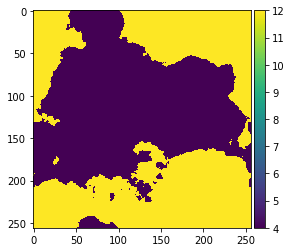

In [33]:
# plot to show the input:
ax = plt.subplot()
im1 = ax.imshow(w1, interpolation='none')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)
plt.show()

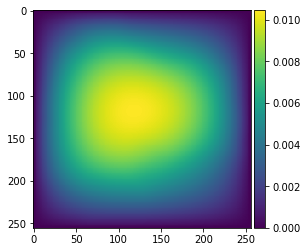

In [34]:
# plot to show the output: 
ax = plt.subplot()
im1 = ax.imshow(output, interpolation='none')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)
plt.show()